# Datasets & Dataloaders

In [1]:
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [3]:
#Datasetの読み込み

training_data = datasets.FashionMNIST( #画像とラベルのペアを順番に取り出せるDatasetオブジェクトが返ってくる
    root="data", #保存先ディレクトリの指定
    train=True, #どちらのデータを読み込むかを指定
    download=True, #データが root に存在しない場合、自動的にダウンロードするかどうか
    transform=ToTensor() #画像の前処理（変換処理）を指定
)

test_data = datasets.FashionMNIST( #型は torchvision.datasets.FashionMNISTクラスのインスタンス
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

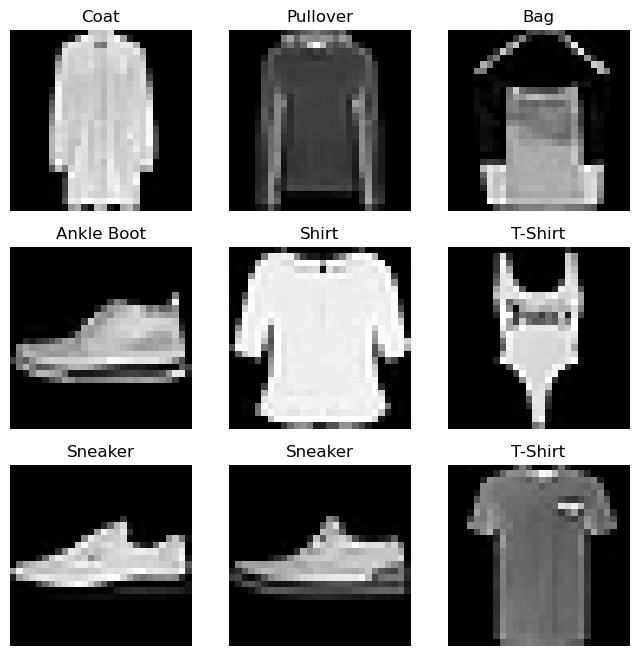

<class 'PIL.Image.Image'>
(28, 28)
<class 'torch.Tensor'>
torch.Size([1, 28, 28])
tensor(0.) tensor(1.)


In [4]:
#データセットの反復処理と可視化（FashionMNISTのランダムな画像を9枚表示する）

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8)) #matplotlibで新しい描画キャンバス（８インチ×８インチ）を作る。
cols, rows = 3, 3 
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint( #整数の乱数生成
        low=0, #乱数の下限
        high=len(training_data), #乱数の上限
        size=(1,) #返すTensorの形状をタプルで指定
    ).item() #randintはテンソルを返す。DatasetはPythonのintを期待しているので、.item()でint型にする必要がある
    img, label = training_data[sample_idx] #インデックスで Dataset にアクセスすると (画像, ラベル) のタプルが返る
    figure.add_subplot(cols, rows, i) #図(figure)の中に「行数 × 列数」のグリッドを作り、そのi番目の位置に描画領域を追加
    plt.title(labels_map[label]) #グラフ（ここでは画像）のタイトルを設定
    plt.axis("off") #x軸・y軸の目盛や枠を非表示にする
    plt.imshow(img.squeeze(), cmap="gray") #squeeze()はサイズ1の次元を削除
                                           #imshow が受け付ける形は、2次元[H, W]（グレースケール）か3次元[H, W, 3/4]（RGB/RGBA） だけ
                                           #FashionMNISTのToTensor()後の画像は形状[1, H, W]
plt.show() #imshow()はfigure上に描画しているだけなので、show()で表示する必要がある

#imgについて
#ToTensor()前
dataset_raw = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)  # transformなし

img1, label = dataset_raw[0]
print(type(img1))
print(img1.size) #サイズ(weight, height)

#ToTensor()後
img2, label = training_data[0]
print(type(img2))       
print(img2.shape) #形状[C, H, W]
print(img2.min(), img2.max()) #正規化済みなので値の範囲は0.0~1.0

In [5]:
#カスタムデータセットの作成
import os
import pandas as pd
from torchvision.io  import read_image

class CustomImageDataset(Dataset): #Datasetを継承しなくても動くが、継承していれば「これは map-style dataset」だと一目で分かる
    def __init__(self, annotations_file, img_dir, transform, target_transform):
        self.img_labels = pd.read_csv(annotations_file) #self.img_labelsはpandas.DataFrame（表）
        self.img_dir = img_dir
        self.transform = transform #画像前処理
        self.target_transform = target_transform #ラベル前処理
    
    def __len__(self): #データ数を返すメソッド。len(dataset)で呼ばれる
        return len(self.img_labels) #len(DataFrame)は行数（=サンプル数）を返す
    
    def __getitem__(self, idx): #インデクシング用のメソッド。dataset[idx]で呼ばれる
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) #ilocは「整数の“位置”で行・列を取るためのインデクサ」
        image = read_image(img_path) #画像を読み込み、Tensor(C,H,W)（通常uint8, 0–255）で取得
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

`__len__()` と `__getitem__()` は必須。これらがないと `DataLoader` は動かない。  

`torch.utils.data.Dataset` には `__len__` と `__getitem__` は **「宣言はあるが未実装（抽象）」**。  

---

**ではなぜ下で DataLoader が動くのか**  
→ `FashionMNIST` は PyTorch の基底 `Dataset` を継承したサブクラスで、  
  自分で `__len__` と `__getitem__` を実装済みだから。

---

**DataLoader 側の動き**
1. `len(training_data)` を呼んで **N（サンプル数）** を取得  
2. サンプラが **インデックス列**（シャッフルならランダム順）を作成  
3. 各インデックスで `training_data[i]`（= `__getitem__`）を呼び出し  
4. **バッチサイズ分集めて** `(batch_images, batch_labels)` に `collate_fn` で束ねて返す


In [6]:
#DataLoaderの使用方法
#DataLoaderはイテラブル（for x in obj: できる反復可能な入れ物）
#DataLoaderはミニバッチ単位でデータを取り出し、各エポックごとにデータをシャッフルするためのもの
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


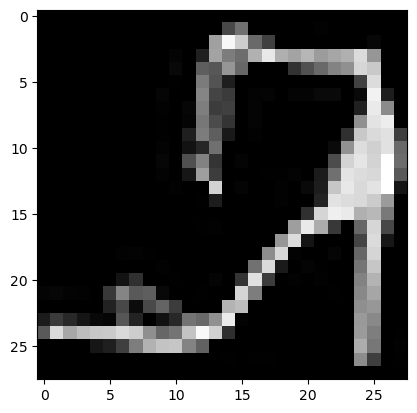

Label: 5


In [7]:
#DataLoaderを用いた繰り返し処理
train_features, train_labels = next(iter(train_dataloader)) #iter()でイテレータ（次の要素を1つずつ返す装置）を生成
                                                            #上のカスタムデータセットのようにgetitemで辞書を返す場合は、valueを取り出す操作も必要
print(f"Feature batch shape: {train_features.size()}") #feature = 入力
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap ="gray")
plt.show()
print(f"Label: {label}")